In [4]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import MarkerCluster
from haversine import haversine
import math
import googlemaps
import os
import time
import polyline
from datetime import datetime
from dotenv import load_dotenv

load_dotenv()

def initialize_google_maps_client(api_key):
    """
    Initialize Google Maps client with API key
    """
    return googlemaps.Client(key=api_key)

def load_gpx_to_dataframe(gpx_file):
    """
    Load a GPX file into a pandas DataFrame with distance calculations
    """
    with open(gpx_file, 'r') as f:
        gpx = gpxpy.parse(f)
    
    # Extract points
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation if point.elevation else 0,
                    'time': point.time
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(points)
    
    # Calculate cumulative distance
    df['segment_distance'] = 0.0
    for i in range(1, len(df)):
        point1 = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        point2 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        df.loc[i, 'segment_distance'] = haversine(point1, point2, unit='km')
    
    df['cumulative_distance'] = df['segment_distance'].cumsum()
    
    # Calculate elevation gain/loss
    df['elevation_change'] = 0.0
    for i in range(1, len(df)):
        df.loc[i, 'elevation_change'] = df.iloc[i]['elevation'] - df.iloc[i-1]['elevation']
    
    df['elevation_gain'] = df['elevation_change'].apply(lambda x: max(0, x))
    df['elevation_loss'] = df['elevation_change'].apply(lambda x: abs(min(0, x)))
    df['cumulative_elevation_gain'] = df['elevation_gain'].cumsum()
    
    return df

def calculate_optimal_rv_stops(route_df, target_distance=125, gmaps_client=None):
    """
    Calculate optimal RV stop locations based on target daily distance
    and check for RV accessibility using Google Maps API
    """
    total_distance = route_df['cumulative_distance'].iloc[-1]
    num_days = math.ceil(total_distance / target_distance)
    
    # Initial stops based on distance
    initial_stops = []
    for day in range(1, num_days):
        target_distance_km = day * target_distance
        # Find the closest point to the target distance
        closest_idx = (route_df['cumulative_distance'] - target_distance_km).abs().idxmin()
        initial_stops.append({
            'day': day,
            'distance_km': route_df.loc[closest_idx, 'cumulative_distance'],
            'latitude': route_df.loc[closest_idx, 'latitude'],
            'longitude': route_df.loc[closest_idx, 'longitude'],
            'elevation': route_df.loc[closest_idx, 'elevation'],
            'elevation_gain_so_far': route_df.loc[closest_idx, 'cumulative_elevation_gain'],
            'index': closest_idx
        })
    
    optimal_stops = []
    
    # If we have Google Maps API access, optimize stops for RV accessibility
    if gmaps_client:
        for stop in initial_stops:
            # Find nearest road accessible point
            reverse_geocode = gmaps_client.reverse_geocode((stop['latitude'], stop['longitude']))
            
            # Check if this is a valid address with road access
            if reverse_geocode and 'formatted_address' in reverse_geocode[0]:
                # Try to find better stopping points nearby (campgrounds, RV parks, etc)
                better_stop = find_better_rv_stop(gmaps_client, stop['latitude'], stop['longitude'])
                
                if better_stop:
                    # Update with better location
                    stop.update({
                        'latitude': better_stop['lat'],
                        'longitude': better_stop['lng'],
                        'place_name': better_stop['name'],
                        'place_address': better_stop['address'],
                        'place_type': better_stop['type']
                    })
                else:
                    # Use the reverse geocoded address
                    stop.update({
                        'place_name': 'Road Stop',
                        'place_address': reverse_geocode[0]['formatted_address'],
                        'place_type': 'road'
                    })
            
            optimal_stops.append(stop)
            
            # Rate limiting to avoid exceeding API quotas
            time.sleep(0.2)
    else:
        # Without Google Maps API, just use the initial stops
        optimal_stops = initial_stops
        
    return optimal_stops

def find_better_rv_stop(gmaps_client, lat, lng, radius=5000):
    """
    Find a better RV stop (campground, RV park, etc.) near the given coordinates
    """
    rv_keywords = ['rv park', 'campground', 'camping', 'rest area', 'truck stop', 'gas station']
    
    for keyword in rv_keywords:
        try:
            # Search for places matching the keyword
            places_result = gmaps_client.places_nearby(
                location=(lat, lng),
                radius=radius,
                keyword=keyword
            )
            
            # If we found any places, return the first one
            if places_result and 'results' in places_result and places_result['results']:
                place = places_result['results'][0]
                
                # Get additional details about the place
                place_details = gmaps_client.place(place['place_id'], fields=['name', 'formatted_address', 'geometry', 'type'])
                
                if place_details and 'result' in place_details:
                    result = place_details['result']
                    return {
                        'name': result.get('name', 'Unnamed Location'),
                        'address': result.get('formatted_address', 'Unknown Address'),
                        'lat': result['geometry']['location']['lat'],
                        'lng': result['geometry']['location']['lng'],
                        'type': keyword
                    }
        except Exception as e:
            print(f"Error searching for {keyword}: {e}")
            
        # Rate limiting
        time.sleep(0.2)
            
    return None

def find_nearby_facilities(gmaps_client, lat, lng, radius=5000):
    """
    Find nearby facilities using Google Maps Places API
    """
    if not gmaps_client:
        # Return dummy data if no API client
        return {
            'has_gas_station': np.random.choice([True, False], p=[0.7, 0.3]),
            'has_grocery': np.random.choice([True, False], p=[0.5, 0.5]),
            'has_lodging': np.random.choice([True, False], p=[0.4, 0.6]),
            'has_water': np.random.choice([True, False], p=[0.8, 0.2])
        }
    
    facilities = {
        'has_gas_station': False,
        'has_grocery': False,
        'has_lodging': False,
        'has_water': True  # Assume water is available by default
    }
    
    # Check for gas stations
    try:
        gas_result = gmaps_client.places_nearby(
            location=(lat, lng),
            radius=radius,
            type='gas_station'
        )
        facilities['has_gas_station'] = bool(gas_result and 'results' in gas_result and gas_result['results'])
    except Exception as e:
        print(f"Error checking for gas stations: {e}")
    
    # Check for grocery stores
    try:
        grocery_result = gmaps_client.places_nearby(
            location=(lat, lng),
            radius=radius,
            type='grocery_or_supermarket'
        )
        facilities['has_grocery'] = bool(grocery_result and 'results' in grocery_result and grocery_result['results'])
    except Exception as e:
        print(f"Error checking for grocery stores: {e}")
    
    # Check for lodging
    try:
        lodging_result = gmaps_client.places_nearby(
            location=(lat, lng),
            radius=radius,
            type='lodging'
        )
        facilities['has_lodging'] = bool(lodging_result and 'results' in lodging_result and lodging_result['results'])
    except Exception as e:
        print(f"Error checking for lodging: {e}")
    
    # Rate limiting
    time.sleep(0.2)
    
    return facilities

def get_route_details(gmaps_client, start_point, end_point, mode="walking"):
    """
    Get route details between two points using Google Maps Directions API
    """
    if not gmaps_client:
        return None
        
    try:
        directions_result = gmaps_client.directions(
            origin=start_point,
            destination=end_point,
            mode=mode,
            alternatives=True
        )
        
        if directions_result:
            return directions_result[0]  # Return the first (recommended) route
    except Exception as e:
        print(f"Error getting directions: {e}")
        
    return None

def analyze_route_segments(route_df, stops, gmaps_client=None):
    """
    Analyze each day's segment for difficulty and key statistics,
    optionally using Google Maps API for terrain data
    """
    segments = []
    
    # Add starting point
    start_point = {
        'day': 0,
        'distance_km': 0,
        'latitude': route_df.iloc[0]['latitude'],
        'longitude': route_df.iloc[0]['longitude'],
        'elevation': route_df.iloc[0]['elevation'],
        'elevation_gain_so_far': 0
    }
    
    all_stops = [start_point] + stops + [{
        'day': len(stops) + 1,
        'distance_km': route_df.iloc[-1]['cumulative_distance'],
        'latitude': route_df.iloc[-1]['latitude'],
        'longitude': route_df.iloc[-1]['longitude'],
        'elevation': route_df.iloc[-1]['elevation'],
        'elevation_gain_so_far': route_df.iloc[-1]['cumulative_elevation_gain']
    }]
    
    for i in range(len(all_stops)-1):
        start = all_stops[i]
        end = all_stops[i+1]
        
        # Filter route for this segment
        start_idx = (route_df['cumulative_distance'] - start['distance_km']).abs().idxmin()
        end_idx = (route_df['cumulative_distance'] - end['distance_km']).abs().idxmin()
        
        segment_df = route_df.iloc[start_idx:end_idx+1].copy()
        
        # Calculate segment statistics
        segment_distance = end['distance_km'] - start['distance_km']
        segment_elevation_gain = end['elevation_gain_so_far'] - start['elevation_gain_so_far']
        
        # Basic difficulty calculation
        difficulty = 1.0
        difficulty += segment_elevation_gain / 500  # Add 1 difficulty point per 500m of elevation gain
        
        # If we have Google Maps API access, get additional data
        terrain_info = {}
        if gmaps_client:
            # Get route details from Google Maps
            start_coord = (start['latitude'], start['longitude'])
            end_coord = (end['latitude'], end['longitude'])
            
            route_details = get_route_details(gmaps_client, start_coord, end_coord)
            
            if route_details:
                # Extract terrain data if available
                if 'legs' in route_details and route_details['legs']:
                    leg = route_details['legs'][0]
                    
                    # Update distance with Google's calculation
                    google_distance = leg['distance']['value'] / 1000  # convert m to km
                    
                    # Check if Google's distance is significantly different
                    if abs(google_distance - segment_distance) > segment_distance * 0.2:
                        # If more than 20% different, adjust difficulty
                        difficulty *= google_distance / segment_distance
                        
                    # Get estimated duration
                    estimated_duration = leg['duration']['text']
                    
                    terrain_info = {
                        'google_distance_km': google_distance,
                        'google_duration': estimated_duration
                    }
                    
                    # Check for warnings or issues
                    if 'warnings' in route_details and route_details['warnings']:
                        terrain_info['warnings'] = route_details['warnings']
                        difficulty += len(route_details['warnings']) * 0.5  # Add difficulty for warnings
        
        segments.append({
            'day': i+1,
            'start_point': (start['latitude'], start['longitude']),
            'end_point': (end['latitude'], end['longitude']),
            'distance_km': segment_distance,
            'elevation_gain_m': segment_elevation_gain,
            'difficulty_score': round(difficulty, 2),
            'estimated_hours': segment_distance / 8,  # Assuming 8 km/h pace
            'terrain_info': terrain_info
        })
        
        # Rate limiting
        if gmaps_client:
            time.sleep(0.5)
    
    return segments

def create_route_map(route_df, stops, gmaps_client=None, route_name="Route"):
    """
    Create an interactive map showing the route and optimal RV stops
    with Google Maps data for more accurate visualization
    """
    # Create a map centered on the route
    center_lat = route_df['latitude'].mean()
    center_lon = route_df['longitude'].mean()
    route_map = folium.Map(location=[center_lat, center_lon], zoom_start=8)
    
    # Add the route line
    points = [(row['latitude'], row['longitude']) for _, row in route_df.iterrows()]
    folium.PolyLine(points, color='blue', weight=3, opacity=0.7, tooltip=f"{route_name} Route").add_to(route_map)
    
    # Add markers for start and end
    folium.Marker(
        [route_df.iloc[0]['latitude'], route_df.iloc[0]['longitude']],
        popup='Start: Santa Monica Pier',
        icon=folium.Icon(color='green', icon='play', prefix='fa')
    ).add_to(route_map)
    
    folium.Marker(
        [route_df.iloc[-1]['latitude'], route_df.iloc[-1]['longitude']],
        popup='End: Las Vegas',
        icon=folium.Icon(color='red', icon='stop', prefix='fa')
    ).add_to(route_map)
    
    # Add markers for RV stops
    for i, stop in enumerate(stops):
        # Get nearby facilities using Google Maps API or simulation
        facilities = find_nearby_facilities(gmaps_client, stop['latitude'], stop['longitude'])
        
        # Create a more detailed popup if place data is available
        if 'place_name' in stop:
            popup_html = f"""
            <b>Day {stop['day']} RV Stop</b><br>
            <b>{stop['place_name']}</b><br>
            {stop.get('place_address', 'No address available')}<br>
            <hr>
            Distance: {stop['distance_km']:.2f} km<br>
            Elevation: {stop['elevation']:.1f} m<br>
            <hr>
            Facilities nearby:<br>
            - Gas station: {'Yes' if facilities['has_gas_station'] else 'No'}<br>
            - Grocery: {'Yes' if facilities['has_grocery'] else 'No'}<br>
            - Lodging: {'Yes' if facilities['has_lodging'] else 'No'}<br>
            - Water: {'Yes' if facilities['has_water'] else 'No'}<br>
            """
        else:
            popup_html = f"""
            <b>Day {stop['day']} RV Stop</b><br>
            Distance: {stop['distance_km']:.2f} km<br>
            Elevation: {stop['elevation']:.1f} m<br>
            <hr>
            Facilities nearby:<br>
            - Gas station: {'Yes' if facilities['has_gas_station'] else 'No'}<br>
            - Grocery: {'Yes' if facilities['has_grocery'] else 'No'}<br>
            - Lodging: {'Yes' if facilities['has_lodging'] else 'No'}<br>
            - Water: {'Yes' if facilities['has_water'] else 'No'}<br>
            """
        
        folium.Marker(
            [stop['latitude'], stop['longitude']],
            popup=folium.Popup(popup_html, max_width=300),
            icon=folium.Icon(
                color='orange', 
                icon='home' if 'place_type' in stop and 'camp' in stop['place_type'] else 'flag',
                prefix='fa'
            )
        ).add_to(route_map)
    
    # Save the map
    map_filename = f"{route_name.replace(' ', '_')}_map.html"
    route_map.save(map_filename)
    
    return route_map, map_filename

def plot_route_comparison(route_data):
    """
    Create visualizations comparing the different routes
    """
    fig = plt.figure(figsize=(15, 12))
    gs = plt.GridSpec(3, 2, height_ratios=[1, 2, 1])
    
    # Plot 1: Basic comparison metrics
    ax1 = fig.add_subplot(gs[0, :])
    
    route_names = list(route_data.keys())
    x = np.arange(len(route_names))
    width = 0.2
    
    distances = [route_data[route]['total_distance'] for route in route_names]
    elevations = [route_data[route]['total_elevation_gain'] for route in route_names]
    days = [route_data[route]['num_days'] for route in route_names]
    
    ax1.bar(x - width, distances, width, label='Distance (km)')
    ax1.bar(x, elevations, width, label='Elevation Gain (m)')
    ax1.bar(x + width, days, width, label='Estimated Days')
    
    ax1.set_title('Route Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(route_names)
    ax1.legend()
    
    # Plot 2: Elevation profiles
    ax2 = fig.add_subplot(gs[1, 0])
    
    for route in route_names:
        df = route_data[route]['df']
        ax2.plot(df['cumulative_distance'], df['elevation'], label=route)
        
        # Mark RV stops on the elevation profile
        for stop in route_data[route]['rv_stops']:
            ax2.scatter(stop['distance_km'], stop['elevation'], color='red', marker='^')
            ax2.text(stop['distance_km'], stop['elevation']+50, f"Day {stop['day']}", fontsize=8)
    
    ax2.set_title('Elevation Profiles')
    ax2.set_xlabel('Distance (km)')
    ax2.set_ylabel('Elevation (m)')
    ax2.grid(True)
    ax2.legend()
    
    # Plot 3: Daily segment comparison
    ax3 = fig.add_subplot(gs[1, 1])
    
    for i, route in enumerate(route_names):
        segments = route_data[route]['segments']
        days = [seg['day'] for seg in segments]
        distances = [seg['distance_km'] for seg in segments]
        difficulties = [seg['difficulty_score'] for seg in segments]
        
        # Size the markers based on difficulty
        sizes = [d * 50 for d in difficulties]
        
        scatter = ax3.scatter(days, distances, s=sizes, label=route, alpha=0.7)
        
        # Add day numbers
        for j, day in enumerate(days):
            ax3.text(day, distances[j]+2, f"D{day}", fontsize=8)
    
    ax3.set_title('Daily Segments Comparison')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Distance (km)')
    ax3.grid(True)
    ax3.legend()
    
    # Plot 4: Summary table
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for route in route_names:
        data = route_data[route]
        segments = data['segments']
        
        # Calculate statistics
        avg_daily_distance = sum(seg['distance_km'] for seg in segments) / len(segments)
        max_daily_elevation = max(seg['elevation_gain_m'] for seg in segments)
        max_difficulty = max(seg['difficulty_score'] for seg in segments)
        hardest_day = [seg['day'] for seg in segments if seg['difficulty_score'] == max_difficulty][0]
        
        table_data.append([
            route,
            f"{data['total_distance']:.1f} km",
            f"{data['total_elevation_gain']:.0f} m",
            f"{avg_daily_distance:.1f} km",
            f"{max_daily_elevation:.0f} m (Day {hardest_day})",
            f"{data['num_days']} days"
        ])
    
    table = ax4.table(
        cellText=table_data,
        colLabels=['Route', 'Total Distance', 'Total Elevation', 'Avg Daily Distance', 'Max Daily Elevation', 'Est. Days'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    plt.tight_layout()
    plt.savefig('route_comparison_with_rv_stops.png', dpi=300)
    plt.show()

def compare_multiple_routes(gpx_files, api_key=None, target_daily_distance=125):
    """
    Compare multiple GPX routes and find optimal RV stops for each,
    with optional Google Maps API integration
    """
    # Initialize Google Maps client if API key is provided
    gmaps_client = initialize_google_maps_client(api_key) if api_key else None
    
    route_data = {}
    
    for gpx_file in gpx_files:
        route_name = gpx_file.split('/')[-1].replace('.gpx', '')
        print(f"Processing route: {route_name}")
        
        # Load and process route
        route_df = load_gpx_to_dataframe(gpx_file)
        
        # Calculate optimal RV stops
        rv_stops = calculate_optimal_rv_stops(route_df, target_daily_distance, gmaps_client)
        
        # Analyze route segments
        segments = analyze_route_segments(route_df, rv_stops, gmaps_client)
        
        # Create map visualization
        route_map, map_filename = create_route_map(route_df, rv_stops, gmaps_client, route_name)
        
        # Store all route data
        route_data[route_name] = {
            'df': route_df,
            'total_distance': route_df['cumulative_distance'].iloc[-1],
            'total_elevation_gain': route_df['cumulative_elevation_gain'].iloc[-1],
            'num_days': len(segments),
            'rv_stops': rv_stops,
            'segments': segments,
            'map_filename': map_filename
        }
    
    # Compare routes and create summary visualization
    plot_route_comparison(route_data)
    
    return route_data

# Main function with Google Maps integration
def main(gpx_files, google_maps_api_key=None, target_daily_distance=125):
    """
    Main function to analyze GPX files with Google Maps API integration
    
    Parameters:
    - gpx_files: List of GPX file paths
    - google_maps_api_key: Google Maps API key (optional)
    - target_daily_distance: Target distance per day in km (default: 125)
    
    Returns:
    - Dictionary with route analysis data
    """
    # Check if API key is provided
    if google_maps_api_key:
        print("Google Maps API integration enabled")
    else:
        print("WARNING: No Google Maps API key provided. Using simulated data for facilities and terrain.")
    
    # Run the analysis
    route_data = compare_multiple_routes(gpx_files, google_maps_api_key, target_daily_distance)
    
    # Print summary
    print("\n=== Route Analysis Summary ===")
    for route_name, data in route_data.items():
        print(f"\nRoute: {route_name}")
        print(f"Total Distance: {data['total_distance']:.1f} km")
        print(f"Total Elevation Gain: {data['total_elevation_gain']:.0f} m")
        print(f"Estimated Days: {data['num_days']}")
        print(f"Map saved to: {data['map_filename']}")
        
        print("\nRV Stop Locations:")
        for stop in data['rv_stops']:
            if 'place_name' in stop:
                print(f"  Day {stop['day']}: {stop['place_name']} ({stop['latitude']:.6f}, {stop['longitude']:.6f})")
            else:
                print(f"  Day {stop['day']}: ({stop['latitude']:.6f}, {stop['longitude']:.6f})")
    
    return route_data


In [ ]:
maps_api_key = os.getenv("MAPS_API_KEY")

In [8]:
gpx_files = ['gpx/HS TSP Solo.gpx', 'gpx/TSP_solo.gpx', 'gpx/JP TSP Solo.gpx']

Google Maps API integration enabled
Processing route: HS TSP Solo
Processing route: TSP_solo
Processing route: JP TSP Solo


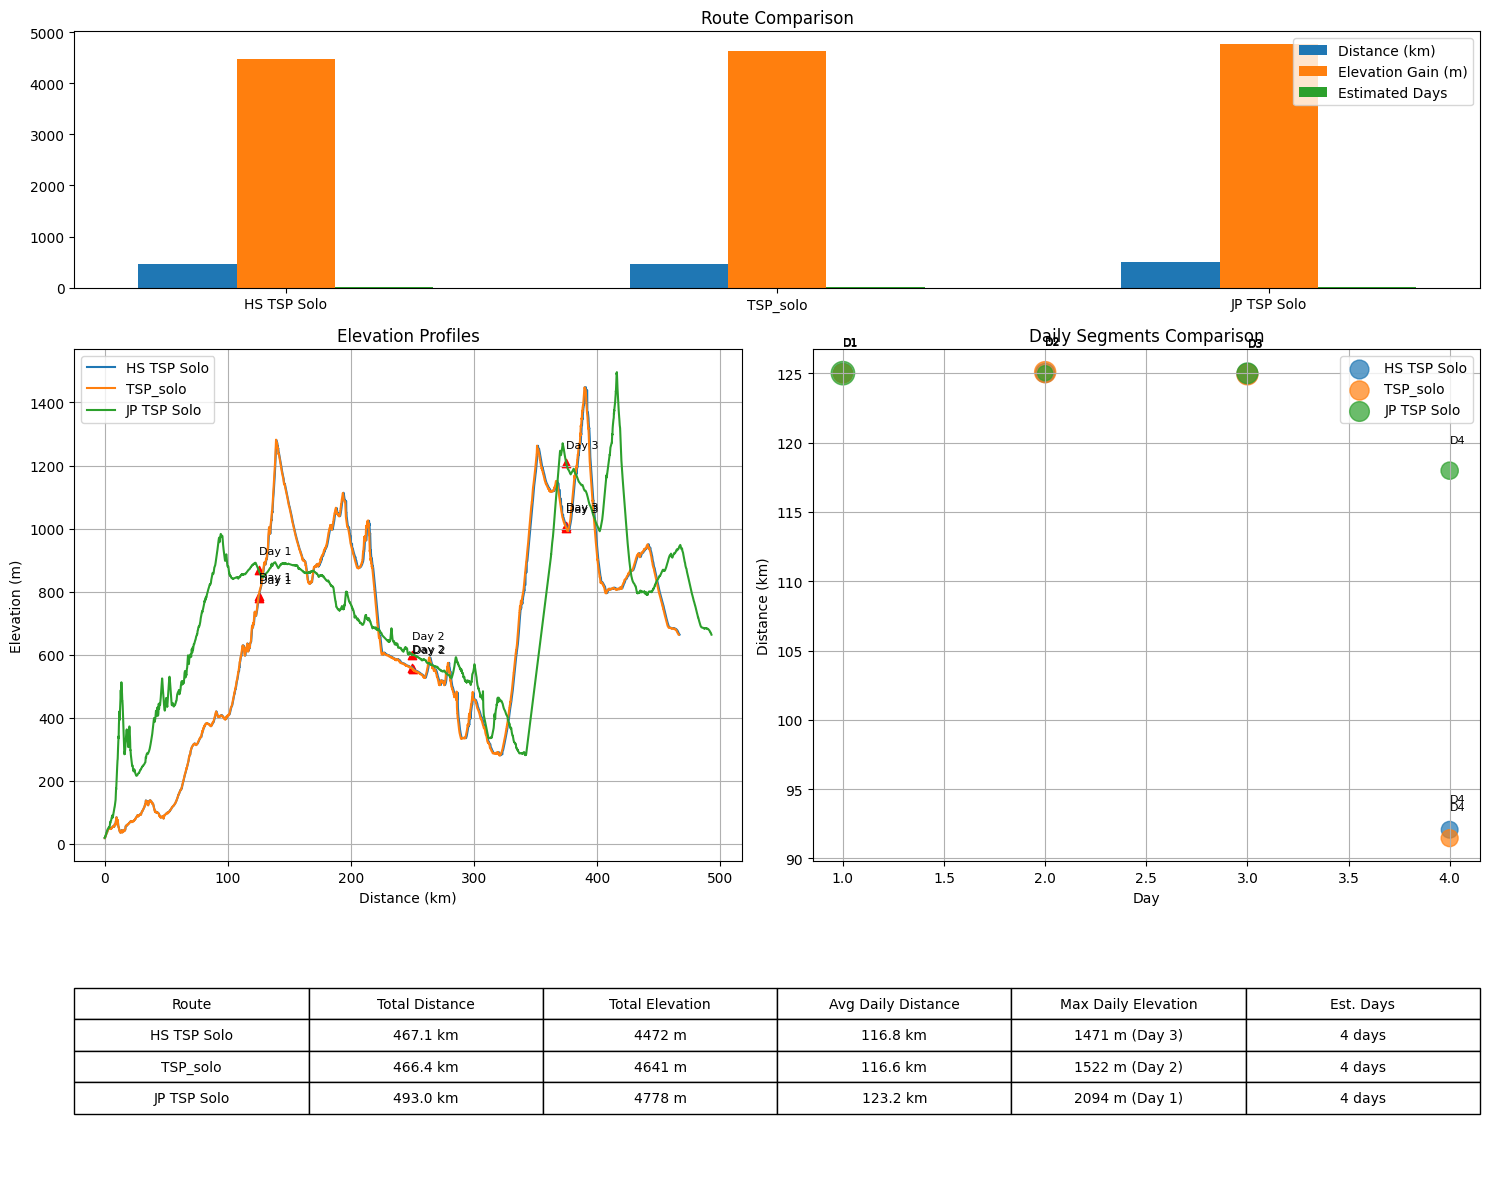


=== Route Analysis Summary ===

Route: HS TSP Solo
Total Distance: 467.1 km
Total Elevation Gain: 4472 m
Estimated Days: 4
Map saved to: HS_TSP_Solo_map.html

RV Stop Locations:
  Day 1: Bonita Ranch Campground (34.236851, -117.499984)
  Day 2: Twin Lakes RV Park (34.903056, -116.651846)
  Day 3: Road Stop (35.537810, -115.707350)

Route: TSP_solo
Total Distance: 466.4 km
Total Elevation Gain: 4641 m
Estimated Days: 4
Map saved to: TSP_solo_map.html

RV Stop Locations:
  Day 1: Bonita Ranch Campground (34.236851, -117.499984)
  Day 2: Circle K (34.966087, -116.643249)
  Day 3: Road Stop (35.543154, -115.708680)

Route: JP TSP Solo
Total Distance: 493.0 km
Total Elevation Gain: 4778 m
Estimated Days: 4
Map saved to: JP_TSP_Solo_map.html

RV Stop Locations:
  Day 1: Four Aces Diner (34.587651, -117.871870)
  Day 2: Desert Springs RV Park (34.885300, -116.887665)
  Day 3: Road Stop (35.406014, -115.761927)


In [9]:
route_analysis = main(gpx_files, maps_api_key, target_daily_distance=125)